# CatBoost Final Model with Holdout Test Scoring

In [3]:
# Imports
import numpy as np
import pandas as pd

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [4]:
df = pd.read_excel('churn_df_data_categorical.xlsx')

## Partition our Data and Pre-processing.

In [5]:
Y = (df["left_flag"] == "Yes") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag"])

In [6]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 25), (1691, 25))

## Training and Fitting the Model

In [7]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cat_cols = ['has_dependents',
 'home_phone',
 'multi_line',
 'contract_term',
 'e_bill_opt_in',
 'pay_method',
 'gender',
 'is_married',
 'recent_offer',
 'internet_tech',
 'unlimited_data_opt']  


cat_pipe = Pipeline([
    ("model", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=99,
        verbose=0,
        allow_writing_files=False 
    ))
])

param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.01, 0.03],
    "model__iterations": [400, 800],
    "model__l2_leaf_reg": [1, 3, 10],

}

cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    return_train_score=True 
)

cat_cv.fit(X_train, Y_train, model__cat_features=cat_cols)

best_model = cat_cv.best_estimator_
print(cat_cv.best_params_)

{'model__depth': 4, 'model__iterations': 400, 'model__l2_leaf_reg': 10, 'model__learning_rate': 0.03}


## Evaluating the Model

In [9]:
from sklearn.metrics import roc_auc_score

best_model = cat_cv.best_estimator_   # pipeline with ("model", CatBoostClassifier)


#printing both AUC (Training and Validation to check the AUC stability)
cv_results = pd.DataFrame(cat_cv.cv_results_)
best_idx = cat_cv.best_index_

# ✅ Training + Validation AUC (from CV)
print(f"Training AUC (CV avg):   {cv_results.loc[best_idx, 'mean_train_score']:.3f}")
print(f"Validation AUC (CV avg): {cv_results.loc[best_idx, 'mean_test_score']:.3f}")


y_test_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(Y_test, y_test_proba)
print(f"CatBoost (tuned) Test AUC: {auc:.3f}")

Training AUC (CV avg):   0.878
Validation AUC (CV avg): 0.845
CatBoost (tuned) Test AUC: 0.853


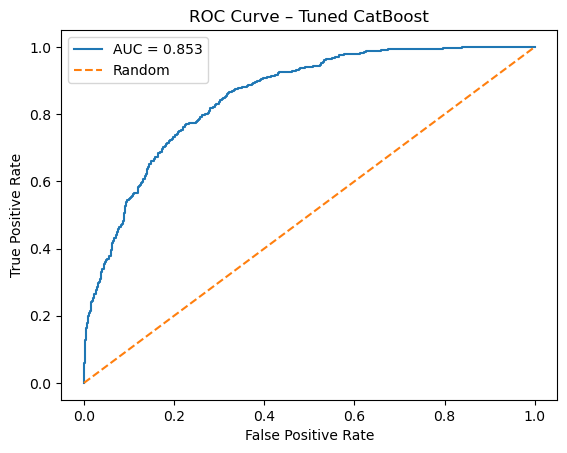

In [10]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned CatBoost")
plt.legend()
plt.show()


Test PR-AUC: 0.6833


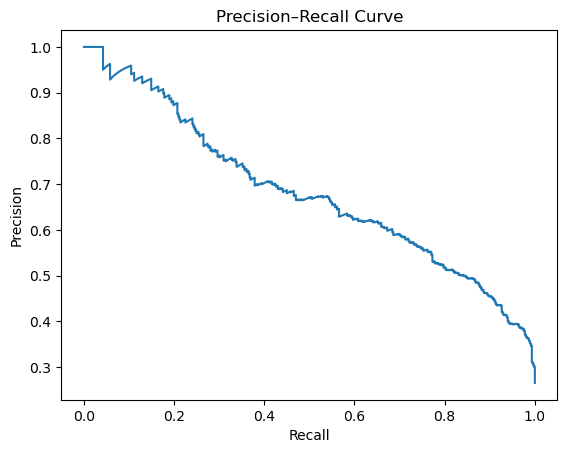

In [11]:
# precision

from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(Y_test, y_test_proba)
print("Test PR-AUC:", round(pr_auc, 4))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(Y_test, y_test_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

## Feature Importance

In [12]:
cb = best_model.named_steps["model"]   
importances = cb.get_feature_importance()  

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
4,contract_term,24.874284
1,tenure_mo,15.095983
7,monthly_fee,12.994850
14,internet_tech,6.164858
20,num_add_ons,4.980338
15,avg_gb_download,4.827842
6,pay_method,4.445720
22,has_streaming,4.102318
18,long_dist_fees_total,3.881418
8,total_billed,2.835758


In [13]:
best_model.named_steps.keys()

dict_keys(['model'])

In [14]:
import matplotlib.pyplot as plt
from catboost import Pool

# 1) Get best fitted CatBoost model from GridSearchCV pipeline
best_cb = cat_cv.best_estimator_.named_steps["model"]

# 2) Choose your SHAP dataset
X_shap = X_test.copy()
X_shap = X_shap.sample(min(1000, len(X_shap)), random_state=42)

# 3) Tell CatBoost which columns are categorical (prevents "Yes" -> float error)
cat_cols = X_shap.select_dtypes(include=["object", "category"]).columns.tolist()

pool = Pool(X_shap, cat_features=cat_cols)

# 4) CatBoost-native SHAP values
shap_vals = best_cb.get_feature_importance(pool, type="ShapValues")

# shap_vals shape = (n_rows, n_features + 1). Last column = expected value
shap_values = shap_vals[:, :-1]

# 5) Mean(|SHAP|) feature importance
imp = pd.Series(np.abs(shap_values).mean(axis=0), index=X_shap.columns).sort_values(ascending=False)

display(imp.head(20))

contract_term            0.658519
tenure_mo                0.392981
monthly_fee              0.382002
pay_method               0.210803
internet_tech            0.181182
num_add_ons              0.152020
has_streaming            0.151116
long_dist_fees_total     0.114453
e_bill_opt_in            0.111442
unlimited_data_opt       0.091433
avg_gb_download          0.076174
total_billed             0.072136
age_years                0.063031
multi_line               0.044622
recent_offer             0.036533
has_add_on               0.028643
overage_ratio_avg        0.023636
avg_long_dist_fee        0.014549
extra_data_fees_total    0.014452
has_dependents           0.014219
dtype: float64

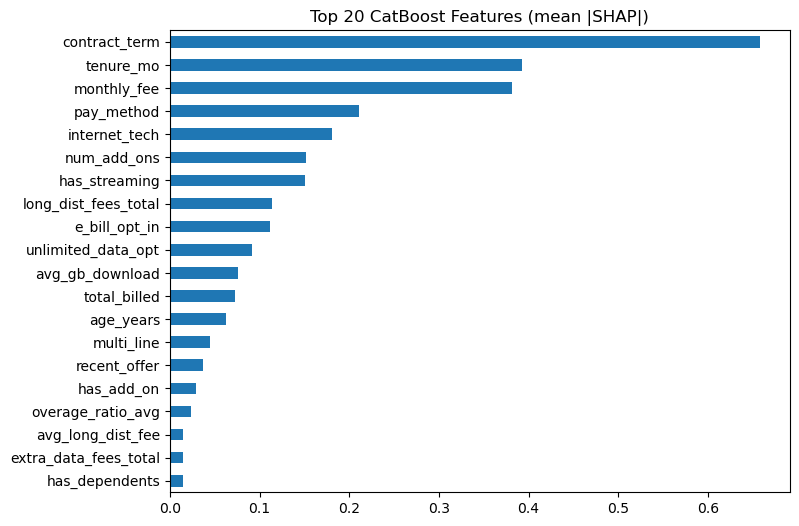

In [15]:
# 6) Plot top 10
plt.figure(figsize=(8, 6))
imp.head(20).sort_values().plot(kind="barh", legend=False)
plt.title("Top 20 CatBoost Features (Mean |SHAP|)")
plt.show()

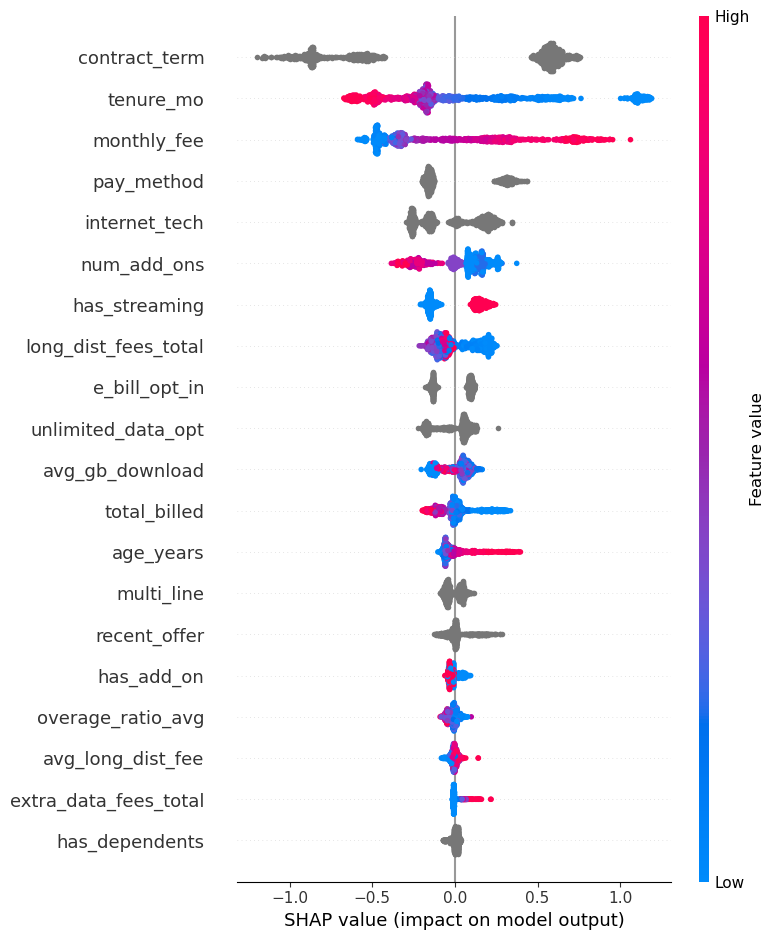

In [16]:
import shap

shap.summary_plot(shap_values, X_shap, max_display=20, show=True)

In [17]:
assert shap_values.shape[1] == X_shap.shape[1], "Mismatch: shap_values columns != X_shap columns"

# Red - high,  Blue - low 
# More dots right - Higher churn 
# More dots left - Lower churn 
# dots - each data point 

## Score Holdout Dataset

In [18]:
holdout = pd.read_excel("churn_df_data_categorical_holdout.xlsx")

In [19]:
Y_hold = (holdout["left_flag"] == "Yes") 
X_hold = holdout.drop(columns=["left_flag"])

In [20]:
Y_test_proba_hold = best_model.predict_proba(X_hold)[:, 1]

In [21]:
auc_hold = roc_auc_score(Y_hold, Y_test_proba_hold)
print(f"CatBoost (tuned) Test AUC: {auc_hold:.3f}")

CatBoost (tuned) Test AUC: 0.859


In [22]:
holdout["predicted_prob"] = Y_test_proba_hold

In [23]:
holdout.to_csv("churn_holdout_scored.csv", index=False)

In [24]:
print(holdout.describe(include='all'))

       has_dependents    tenure_mo home_phone multi_line   contract_term  \
count            1407  1407.000000       1407       1407            1407   
unique              2          NaN          2          3               3   
top                No          NaN        Yes         No  Month-to-month   
freq              976          NaN       1282        686             778   
mean              NaN    32.074627        NaN        NaN             NaN   
std               NaN    24.739484        NaN        NaN             NaN   
min               NaN     0.000000        NaN        NaN             NaN   
25%               NaN     9.000000        NaN        NaN             NaN   
50%               NaN    27.000000        NaN        NaN             NaN   
75%               NaN    56.000000        NaN        NaN             NaN   
max               NaN    72.000000        NaN        NaN             NaN   

       e_bill_opt_in        pay_method  monthly_fee  total_billed left_flag  \
count   